# Dynamic web scraping script from OpenBudget website

# Functions

In [171]:
import pandas as pd
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.action_chains import ActionChains

DRIVER_PATH = '/Users/lilycao/Downloads/chromedriver'

In [326]:
def get_url(year, name_type, agency=None):
    '''
    Creates url based on year, choice of department or program breakdown, and choice of agency breakdown.
    
    Inputs:
    year: integer
    name_type: string ('department','program')
        - Choose 'department' for LA city breakdown by department & department breakdown by program (i.e. Police)
        - Choose 'program' for LA city breakdown by program
    agency: string (choose from dept_list)
    
    Output: string
    '''
    url = 'http://openbudget.lacity.org/#!/year/' + str(year) + '/operating/0/' + name_type +'_name'
    
    if agency:
        url += '/' + agency + '/0/program_name'
        
    return url

In [13]:
def choose_vis(url, vis_type):
    '''
    Creates url of webpage with the visualization of choice displayed 
    
    Inputs: 
    url: string
    vis_type: string
        options: 
            - none: horizontal bar chart
            - 'pieChart': pie chart
            - 'lineChart': line chart of budgets over time
    
    Output: string
    '''
    url += '?vis=' + vis_type
    return url

In [14]:
def get_all_text(driver):
    '''
    Finds td tags and extracts texts from those with text length's greater than 0
    
    Input: driver
    Output: list of strings
    '''
    all_text = []
    for i in driver.find_elements_by_tag_name('td'):
        if len(i.text) > 0:
            all_text.append(i.text)

    all_text += ['100%']
    
    return all_text

In [15]:
def create_col_lists(all_text, start_index):
    '''
    Creates a list from the list of all texts starting from a given index
    and jumping by 3 indeces
    
    Inputs:
    all_text: list of strings
    start_index: integer
    
    Output: list of strings
    '''
    elem_list = []
    for i in list(range(start_index, len(all_text), 3)):
        elem = all_text[i]
        if '$' in elem:
            elem = elem[elem.find('$'):]
        elem_list.append(elem)
        
    return elem_list

In [520]:
def create_df(name_list, budget_list, percentage_list, name_type):
    '''
    Creates a dataframe from three lists: department/fund/program names, budgets, 
    and percentages of the total budget.
    
    Inputs:
    name_list: list of strings
    budget_list: list of strings
    percentage_list: list of strings
    name_type: string
    
    Ouput: a dataframe
    '''
    dict = {str(name_type): name_list,
           'Appropriated': budget_list,
           '% of Total': percentage_list}

    budget_df = pd.DataFrame(dict) 
    
    return budget_df

In [247]:
def close_driver(driver):
    '''
    Closes driver
    
    Input: driver
    
    Output: none
    '''
    driver.close()

In [259]:
def convert_to_float(df, column_name):
    '''
    Convert column values from string to float
    
    Inputs:
    df: dataframe
    column_name: string 
    
    Output: none 
    '''
    new_values = []
    for value in df[column_name]:
        value = re.sub(r'[$,%]', '', str(value))
        new_values.append(float(value))
    df[column_name] = new_values

In [260]:
def find_col_diffs(df, col_1_name, col_2_name):
    '''
    Calculate differences between two columns
    
    Inputs:
    df: dataframe
    col_1_name: string (col of original budget)
    col_2_name: string (col of new budget)
    
    Output: list of percentage change
    '''
    diff = df[col_2_name] - df[col_1_name]
    percent_diff = (diff/df[col_1_name]) * 100
    return percent_diff

In [521]:
def get_tech_urls(year):
    '''
    Technology Support is a program within LA city's budget and on Open Budget, it is
    split into different priority outcomes. For example, in 2020, the two categories were
    'A Livable and Sustainable City' and 'Not Categorized.' This functions returns urls for
    each of these categories.
    
    Input: year (integer)
    
    Output: dictionary mapping priority outcome under tech support to correct url
    '''
    tech = get_url(year, 'program') + '/Technology+Support/0/program_priority'
    driver_tech = webdriver.Chrome(executable_path=DRIVER_PATH)
    driver_tech.get(tech)
    
    all_tech = get_all_text(driver_tech)
    tech_outcomes = create_col_lists(all_tech, 0)
    tech_budgets = create_col_lists(all_tech, 1)
    tech_percents= create_col_lists(all_tech, 2)
    
    LA_tech = create_df(tech_outcomes, tech_budgets, tech_percents, 'Outcome')
    close_driver(driver_tech)
    
    dict = {}
    for j in LA_tech[:-1]['Outcome']:
        url = get_url(year, 'program') + '/Technology+Support/0/program_priority/'

        if 'Not Categorized' in j:
            url += 'Not+Categorized/0/department_name'
            if year == 2020:
                url += '/Building+and+Safety/0/source_fund_name'

        elif 'N/A' in j:
            url += '/0/department_name'

        else:
            url_j = j.replace(' ', '+')
            url += url_j + '/0/department_name'
        
        for i in range(len(LA_tech) - 1):
            dict[j] = url
                    
    return dict

In [615]:
def create_tech_dfs(year):
    '''
    Create dataframes for technology support budgets
    
    Input: year(integer)
    
    Output: list of dataframes 
    '''
    tech_urls = get_tech_urls(year)
    tech_dfs = []
    for outcome, url in tech_urls.items():
        driver_tech = webdriver.Chrome(executable_path=DRIVER_PATH)
        driver_tech.get(url)

        all_tech = get_all_text(driver_tech)

        tech_cat = create_col_lists(all_tech, 0)
        tech_budgets = create_col_lists(all_tech, 1)
        tech_percents = create_col_lists(all_tech, 2)

        LA_tech = create_df(tech_cat, tech_budgets, tech_percents, 'Department/Fund/Expense')
        close_driver(driver_tech)

        tech_dfs.append(LA_tech)
    
    return tech_dfs

In [539]:
def merge_20_21(budget_20, budget_21, name_type):
    '''
    Takes two dataframes from different FY periods, merges them, and creates % change column
    
    Inputs:
    budget_20: dataframe of budget from FY2019-20
    budget_21: dataframe of budget from FY2020-21
    name_type: string ('Department/Fund', 'Program')
    
    Output: merged dataframe 
    '''
    merged = budget_20.merge(budget_21, on=name_type, how='right')
    merged = merged.fillna(0)
    merged.columns = [name_type, 'FY20 Appropriated', 'FY20 % of Total','FY21 Appropriated', 'FY21 % of Total']
    
    for col in merged.columns[1:]:
        convert_to_float(merged, col)
    
    merged['FY20, FY21 % Change'] = find_col_diffs(merged, 'FY20 Appropriated', 'FY21 Appropriated')
    return merged

In [610]:
def merged_bar_plot(merged_df):
    '''
    Creates a vertical bar plot for a merged dataframe of FY20 and FY21 budgets
    
    Input: merged_df (dataframe of FY20 and FY21 merged dfs)
    Output: bar plot where departments/funds/programs are the x-axis and appropriations are the y-axis
    '''
    name_type = merged_df.columns[0]
    approp = merged_df[[name_type, 'FY20 Appropriated','FY21 Appropriated']]
    return approp.plot.bar(x=name_type, figsize=(20,10))

# Example Applications

## LA City
1) 2020-21 LA City Proposed Budget - Deparments: **LA_proposed_2020_21**  
2) 2020-21 LA City Proposed Budget - Programs: **LA_proposed_2020_21_progs**   
3) 2019-20 LA City Accepted Budget - Deparments: **LA_accep_2019_20**    
4) 2019-20 LA City Accepted Budget - Programs: **LA_accep_2019_20_progs**    
5) Combination LA City Departments: **LA_dept_merged**  + bar plot  
6) Combination LA City Programs: **LA_progs_merged**   

----
## LAPD
7) 2020-21 LAPD Proposed Budget: **LAPD_proposed_2020_21_progs**    
8) 2019-20 LAPD Accepted Budget: **LAPD_accep_2019_20_progs**  
9) Combination: **LAPD_merged** + bar plot

----
## LADOT
10) 2020-21 LADOT Proposed Budget: **LADOT_proposed_2020_21_progs**      
11) 2019-20 LADOT Accepted Budget: **LADOT_accep_2019_20_progs**  
12) Combination: **LADOT_merged** + bar plot

----
## Technology Support
13) 2020 - 21 Technology Support (Program): **tech_21**    
14) 2019 - 20 Technology Support (Program): **tech_20**     
15) Combination: **tech_merged** + bar plot

## 2020-21 LA City Proposed Budget - Departments 

In [308]:
driver = webdriver.Chrome(executable_path=DRIVER_PATH)
driver.get(get_url(2021, 'department'))

In [309]:
all_text = get_all_text(driver)

In [310]:
# Department/Funds 
dept_list = create_col_lists(all_text, 0)

# Budgets 
budget_list = create_col_lists(all_text, 1)

# Percentages of Total
percentage_list = create_col_lists(all_text, 2)

In [510]:
LA_proposed_2020_21 = create_df(dept_list, budget_list, percentage_list, 'Department/Fund')
LA_proposed_2020_21.head()

,Department/Fund,Appropriated,% of Total
0,Police,"$1,857,330,549",17.64%
1,Tax and Revenue Anticipation Notes,"$1,323,536,029",12.57%
2,Other Special Purpose Funds,"$1,313,794,429",12.48%
3,Human Resources Benefits,"$800,593,969",7.60%
4,Fire,"$732,243,241",6.95%


In [312]:
close_driver(driver)

## 2020-21 LA City Proposed Budget - Programs

In [208]:
driver2 = webdriver.Chrome(executable_path=DRIVER_PATH)
driver2.get(get_url(2021, 'program'))

In [209]:
all_text2 = get_all_text(driver2)

In [210]:
# Programs
prog_list = create_col_lists(all_text2, 0)

# Budgets 
budget_list2 = create_col_lists(all_text2, 1)

# Percentages of Total
percentage_list2 = create_col_lists(all_text2, 2)

In [511]:
LA_proposed_2020_21_progs = create_df(prog_list, budget_list2, percentage_list2, 'Program')
LA_proposed_2020_21_progs.head()

,Program,Appropriated,% of Total
0,Tax and Revenue Anticipation Notes Debt Servic...,"$1,323,536,029",12.57%
1,Field Forces,"$948,153,028",9.00%
2,Human Resources Benefits,"$800,593,969",7.60%
3,"Wastewater Collection, Treatment, and Disposal","$576,990,112",5.48%
4,Building and Safety Building Permit Enterprise...,"$380,536,770",3.61%


In [212]:
close_driver(driver2)

## 2019-20 LA City Accepted Budget - Departments

In [87]:
driver3 = webdriver.Chrome(executable_path=DRIVER_PATH)
driver3.get(get_url(2020, 'department'))

In [88]:
all_text3 = get_all_text(driver3)

In [89]:
# Departments/Funds
dept_list2 = create_col_lists(all_text3, 0)

# Budgets 
budget_list3 = create_col_lists(all_text3, 1)

# Percentages of Total
percentage_list3 = create_col_lists(all_text3, 2)

In [523]:
LA_accep_2019_20 = create_df(dept_list2, budget_list3, percentage_list3, 'Department/Fund')
LA_accep_2019_20.head()

,Department/Fund,Appropriated,% of Total
0,Police,"$1,733,838,124",16.19%
1,Other Special Purpose Funds,"$1,363,287,596",12.73%
2,Tax and Revenue Anticipation Notes,"$1,302,296,587",12.16%
3,Human Resources Benefits,"$743,564,377",6.94%
4,Fire,"$691,009,340",6.45%


In [91]:
close_driver(driver3)

## 2019-20 LA City Accepted Budget - Programs

In [213]:
driver4 = webdriver.Chrome(executable_path=DRIVER_PATH)
driver4.get(get_url(2020, 'program'))

In [214]:
all_text4 = get_all_text(driver4)

In [215]:
# Programs
prog_list2 = create_col_lists(all_text4, 0)

# Budgets 
budget_list4 = create_col_lists(all_text4, 1)

# Percentages of Total
percentage_list4 = create_col_lists(all_text4, 2)

In [524]:
LA_accep_2019_20_progs = create_df(prog_list2, budget_list4, percentage_list4, 'Program')
LA_accep_2019_20_progs.head()

,Program,Appropriated,% of Total
0,Tax and Revenue Anticipation Notes Debt Servic...,"$1,302,296,587",12.16%
1,Field Forces,"$871,402,544",8.14%
2,Human Resources Benefits,"$743,564,377",6.94%
3,"Wastewater Collection, Treatment, and Disposal","$597,021,942",5.57%
4,Building and Safety Building Permit Enterprise...,"$377,092,942",3.52%


In [217]:
close_driver(driver4)

## Combination LA City Budgets - Departments: 2019-20 VS 2020-21

In [531]:
LA_dept_merged = merge_20_21(LA_accep_2019_20, LA_proposed_2020_21, 'Department/Fund')
LA_dept_merged.head()

,Department/Fund,FY20 Appropriated,FY20 % of Total,FY21 Appropriated,FY21 % of Total,"FY20, FY21 % Change"
0,Police,1.733838e+09,16.19,1.857331e+09,17.64,7.122489
1,Other Special Purpose Funds,1.363288e+09,12.73,1.313794e+09,12.48,-3.630427
2,Tax and Revenue Anticipation Notes,1.302297e+09,12.16,1.323536e+09,12.57,1.630922
3,Human Resources Benefits,7.435644e+08,6.94,8.005940e+08,7.60,7.669758
4,Fire,6.910093e+08,6.45,7.322432e+08,6.95,5.967199


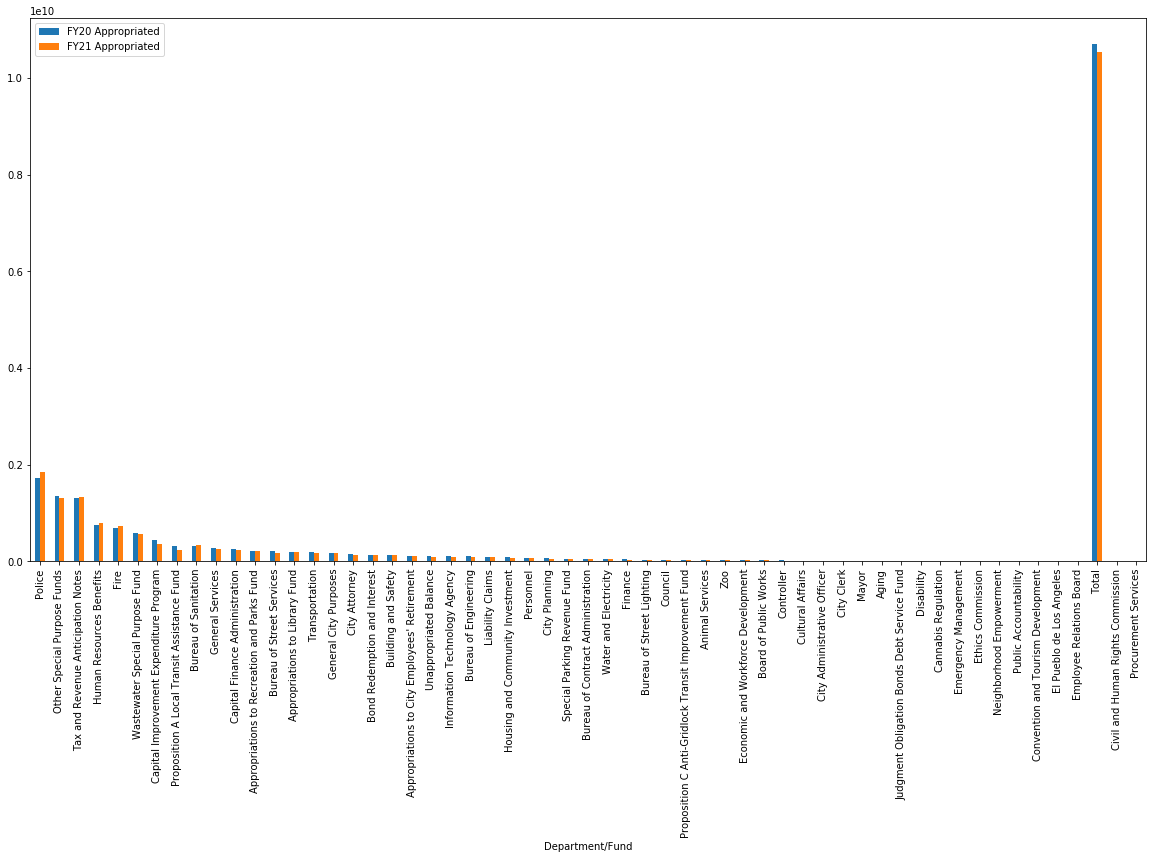

In [606]:
merged_bar_plot(LA_dept_merged)

## Combination LA City Budgets - Programs: 2019-20 VS 2020-21

In [534]:
LA_progs_merged = merge_20_21(LA_accep_2019_20_progs, LA_proposed_2020_21_progs, 'Program')
LA_progs_merged.head()

,Program,FY20 Appropriated,FY20 % of Total,FY21 Appropriated,FY21 % of Total,"FY20, FY21 % Change"
0,Tax and Revenue Anticipation Notes Debt Servic...,1.302297e+09,12.16,1.323536e+09,12.57,1.630922
1,Field Forces,8.714025e+08,8.14,9.481530e+08,9.00,8.807696
2,Human Resources Benefits,7.435644e+08,6.94,8.005940e+08,7.60,7.669758
3,"Wastewater Collection, Treatment, and Disposal",5.970219e+08,5.57,5.769901e+08,5.48,-3.355292
4,Building and Safety Building Permit Enterprise...,3.770929e+08,3.52,3.805368e+08,3.61,0.913257


## 2020-21 LAPD Proposed Budget

In [262]:
driver5 = webdriver.Chrome(executable_path=DRIVER_PATH)
driver5.get(get_url(2021, 'department', 'Police'))

In [263]:
all_text5 = get_all_text(driver5)

In [264]:
# Programs
prog_list3 = create_col_lists(all_text5, 0)

# Budgets 
budget_list5 = create_col_lists(all_text5, 1)

# Percentages of Total
percentage_list5 = create_col_lists(all_text5, 2)

In [516]:
LAPD_proposed_2020_21_progs = create_df(prog_list3, budget_list5, percentage_list5, 'Program')
LAPD_proposed_2020_21_progs

,Program,Appropriated,% of Total
0,Field Forces,"$948,153,028",51.05%
1,Specialized Investigation,"$194,655,099",10.48%
2,Specialized Enforcement and Protection,"$193,169,157",10.40%
3,Departmental Support,"$124,440,204",6.70%
4,Personnel Training and Support,"$91,353,016",4.92%
5,Traffic Control,"$88,188,675",4.75%
6,Custody of Persons and Property,"$65,604,313",3.53%
7,Technology Support,"$64,427,092",3.47%
8,Internal Integrity and Standards Enforcement,"$60,450,976",3.25%
9,General Administration and Support,"$26,888,989",1.45%


In [269]:
close_driver(driver5)

## 2019-20 LAPD Accepted Budget

In [270]:
driver6 = webdriver.Chrome(executable_path=DRIVER_PATH)
driver6.get(get_url(2020, 'department', 'Police'))

In [271]:
all_text6 = get_all_text(driver6)

In [272]:
# Programs
prog_list4 = create_col_lists(all_text6, 0)

# Budgets 
budget_list6 = create_col_lists(all_text6, 1)

# Percentages of Total
percentage_list6 = create_col_lists(all_text6, 2)

In [517]:
LAPD_accep_2019_20_progs = create_df(prog_list4, budget_list6, percentage_list6, "Program")
LAPD_accep_2019_20_progs

,Program,Appropriated,% of Total
0,Field Forces,"$871,402,544",50.26%
1,Specialized Investigation,"$190,135,966",10.97%
2,Specialized Enforcement and Protection,"$158,987,488",9.17%
3,Departmental Support,"$131,813,554",7.60%
4,Personnel Training and Support,"$84,235,064",4.86%
5,Traffic Control,"$80,806,956",4.66%
6,Custody of Persons and Property,"$67,034,924",3.87%
7,Technology Support,"$66,150,304",3.82%
8,Internal Integrity and Standards Enforcement,"$56,909,500",3.28%
9,General Administration and Support,"$26,361,824",1.52%


In [274]:
close_driver(driver6)

## Combination LAPD Budgets: 2019-20 VS 2020-21

In [536]:
LAPD_merged = merge_20_21(LAPD_accep_2019_20_progs, LAPD_proposed_2020_21_progs, 'Program')
LAPD_merged.head()

,Program,FY20 Appropriated,FY20 % of Total,FY21 Appropriated,FY21 % of Total,"FY20, FY21 % Change"
0,Field Forces,871402544.0,50.26,948153028.0,51.05,8.807696
1,Specialized Investigation,190135966.0,10.97,194655099.0,10.48,2.376790
2,Specialized Enforcement and Protection,158987488.0,9.17,193169157.0,10.40,21.499597
3,Departmental Support,131813554.0,7.60,124440204.0,6.70,-5.593772
4,Personnel Training and Support,84235064.0,4.86,91353016.0,4.92,8.450106


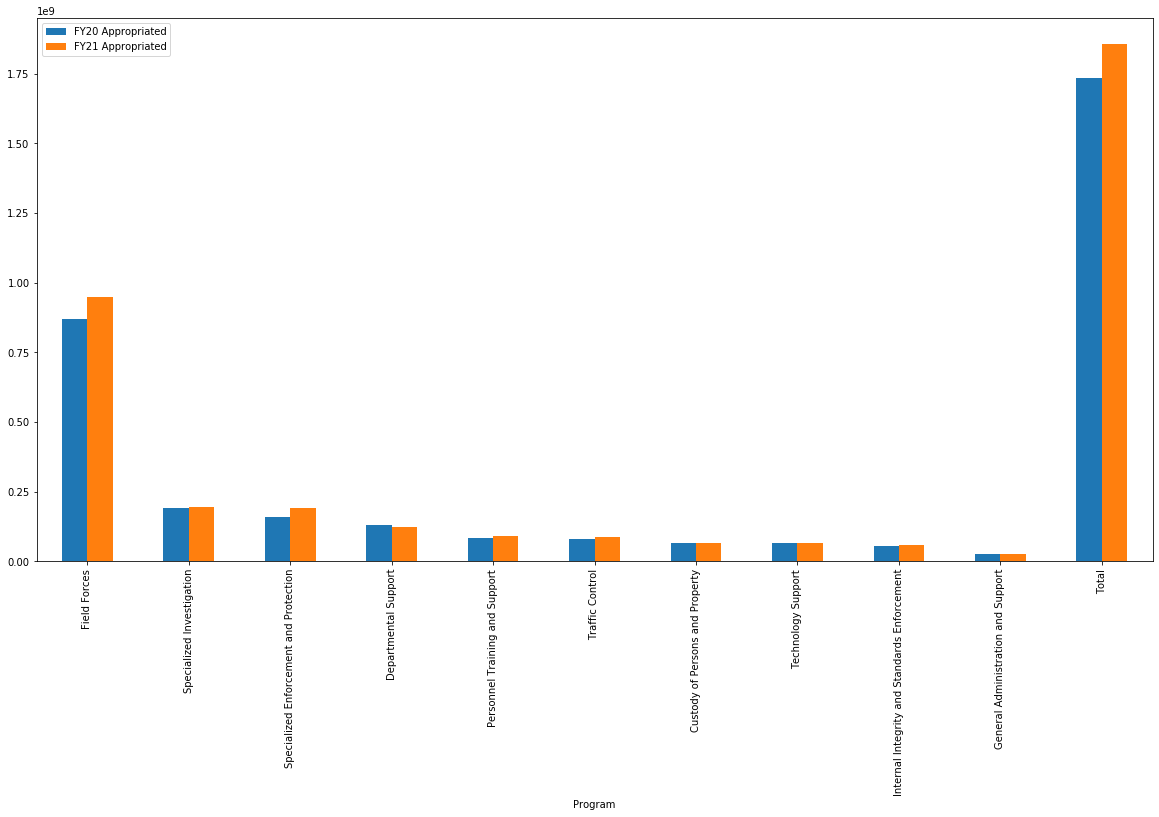

In [608]:
merged_bar_plot(LAPD_merged)

## 2020-21 LADOT Proposed Budget

In [282]:
driver7 = webdriver.Chrome(executable_path=DRIVER_PATH)
driver7.get(get_url(2021, 'department', 'Transportation'))

In [283]:
all_text7 = get_all_text(driver7)

In [284]:
# Programs
prog_list5 = create_col_lists(all_text7, 0)

# Budgets 
budget_list7 = create_col_lists(all_text7, 1)

# Percentages of Total
percentage_list7 = create_col_lists(all_text7, 2)

In [518]:
LADOT_proposed_2020_21_progs = create_df(prog_list5, budget_list7, percentage_list7, "Program")
LADOT_proposed_2020_21_progs

,Program,Appropriated,% of Total
0,Parking Enforcement Services,"$60,425,872",33.50%
1,Traffic Signals and Systems,"$24,085,724",13.35%
2,Streets and Sign Management,"$22,499,194",12.47%
3,Parking Citation Processing Services,"$14,053,740",7.79%
4,Crossing Guard Services,"$7,894,421",4.38%
5,General Administration and Support,"$6,694,046",3.71%
6,"Parking Facilities, Meters, and Operations","$6,655,674",3.69%
7,District Offices,"$6,139,932",3.40%
8,Active Transportation,"$4,913,707",2.72%
9,Major Project Coordination,"$4,889,247",2.71%


In [286]:
close_driver(driver7)

## 2019-20 LADOT Accepted Budget

In [313]:
driver8 = webdriver.Chrome(executable_path=DRIVER_PATH)
driver8.get(get_url(2020, 'department', 'Transportation'))

In [314]:
all_text8 = get_all_text(driver8)

In [315]:
# Programs
prog_list6 = create_col_lists(all_text8, 0)

# Budgets 
budget_list8 = create_col_lists(all_text8, 1)

# Percentages of Total
percentage_list8 = create_col_lists(all_text8, 2)

In [519]:
LADOT_accep_2019_20_progs = create_df(prog_list6, budget_list8, percentage_list8, "Program")
LADOT_accep_2019_20_progs

,Program,Appropriated,% of Total
0,Parking Enforcement Services,"$60,022,647",32.10%
1,Traffic Signals and Systems,"$27,010,867",14.45%
2,Streets and Sign Management,"$23,469,210",12.55%
3,Parking Citation Processing Services,"$14,377,821",7.69%
4,Crossing Guard Services,"$7,620,727",4.08%
5,"Parking Facilities, Meters, and Operations","$7,426,127",3.97%
6,General Administration and Support,"$7,374,419",3.94%
7,Active Transportation,"$5,500,179",2.94%
8,Public Transit Services,"$5,357,192",2.87%
9,District Offices,"$5,346,128",2.86%


In [317]:
close_driver(driver8)

## Combination LADOT Budgets: 2019-20 VS 2020-21

In [537]:
LADOT_merged = merge_20_21(LADOT_accep_2019_20_progs, LADOT_proposed_2020_21_progs, 'Program')
LADOT_merged.head()

,Program,FY20 Appropriated,FY20 % of Total,FY21 Appropriated,FY21 % of Total,"FY20, FY21 % Change"
0,Parking Enforcement Services,60022647.0,32.10,60425872.0,33.50,0.671788
1,Traffic Signals and Systems,27010867.0,14.45,24085724.0,13.35,-10.829504
2,Streets and Sign Management,23469210.0,12.55,22499194.0,12.47,-4.133143
3,Parking Citation Processing Services,14377821.0,7.69,14053740.0,7.79,-2.254034
4,Crossing Guard Services,7620727.0,4.08,7894421.0,4.38,3.591442


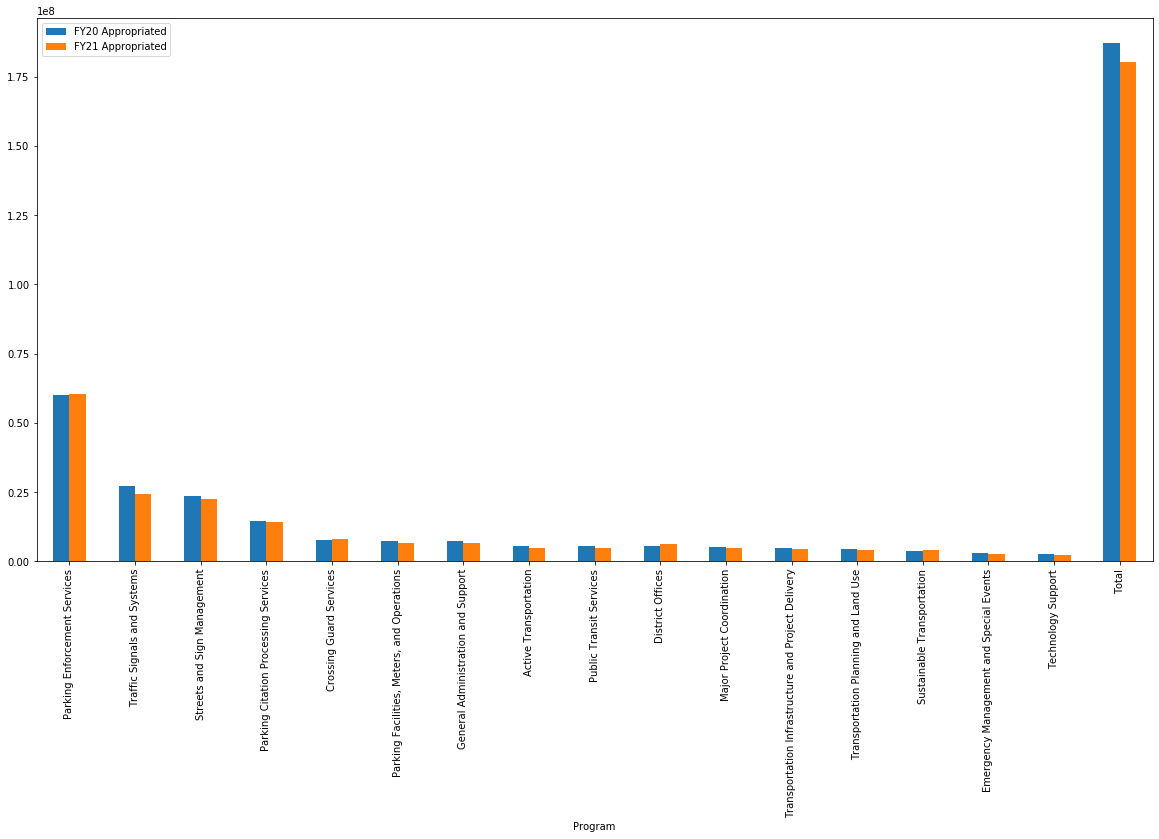

In [609]:
merged_bar_plot(LADOT_merged)

# 2020 - 21 Technology Support (Program)

### Two tables: 
#### N/A (Department/Fund)
#### Not Categorized (Expense)

In [616]:
tech_21 = create_tech_dfs(2021)[0]
tech_21

,Department/Fund/Expense,Appropriated,% of Total
0,Police,"$64,427,092",60.35%
1,Bureau of Sanitation,"$11,735,791",10.99%
2,Fire,"$11,147,539",10.44%
3,City Planning,"$9,713,253",9.10%
4,Housing and Community Investment,"$3,439,245",3.22%
5,Transportation,"$2,185,590",2.05%
6,Economic and Workforce Development,"$1,584,901",1.48%
7,Personnel,"$1,223,223",1.15%
8,City Clerk,"$961,319",0.90%
9,Zoo,"$335,388",0.31%


# 2019 - 20 Technology Support (Program)

### Two tables: 
#### A Livable and Sustainable City (Department/Fund)
#### Not Categorized (Expense)

In [617]:
tech_20 = create_tech_dfs(2020)[0]
tech_20

,Department/Fund/Expense,Appropriated,% of Total
0,Police,"$66,150,304",59.11%
1,Fire,"$13,711,003",12.25%
2,Bureau of Sanitation,"$11,556,615",10.33%
3,City Planning,"$10,393,412",9.29%
4,Housing and Community Investment,"$4,165,240",3.72%
5,Transportation,"$2,537,544",2.27%
6,Economic and Workforce Development,"$1,723,833",1.54%
7,City Clerk,"$991,796",0.89%
8,Zoo,"$675,400",0.60%
9,Total,"$111,905,147",100%


# Combination Technology Support Budgets: 2019-20 VS 2020-21

In [618]:
tech_merged = merge_20_21(tech_20, tech_21, 'Department/Fund/Expense')
tech_merged.head()

,Department/Fund/Expense,FY20 Appropriated,FY20 % of Total,FY21 Appropriated,FY21 % of Total,"FY20, FY21 % Change"
0,Police,66150304.0,59.11,64427092.0,60.35,-2.604995
1,Fire,13711003.0,12.25,11147539.0,10.44,-18.696400
2,Bureau of Sanitation,11556615.0,10.33,11735791.0,10.99,1.550419
3,City Planning,10393412.0,9.29,9713253.0,9.10,-6.544136
4,Housing and Community Investment,4165240.0,3.72,3439245.0,3.22,-17.429848


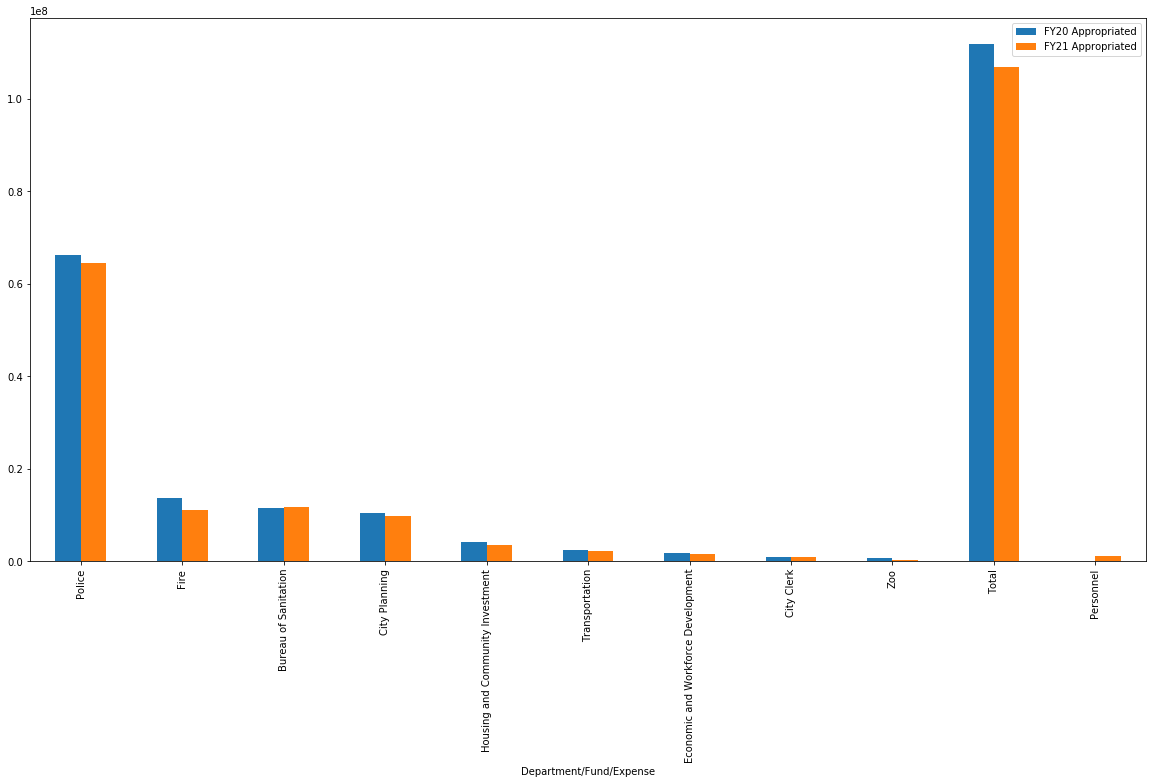

In [619]:
merged_bar_plot(tech_merged)